<a href="https://colab.research.google.com/github/divyanshgupt/travelling-wave-mec/blob/main/Grid_Cells_with_Theta_Rhythm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
#import torch

# Position Theta Phase Model from McClain et al., 2019:

**Spatial Input Equation**: (Gaussian to model place cell field)
$$ f = e^{A_x}e^{\frac{-(x-x_0)^2}{2\sigma^2_x}}  $$

**Phase modulation equation**:
$$ g(\theta,x) = e^{k_\theta(cos(\theta - \theta_0(x)) - 1)} $$

**Phase precession equation**:
$$ \theta_0(x) = b_\theta + m_\theta(x - x_0) $$

$ b_\theta = 0 $: preferred phase at the center of the place field

$ m_\theta = 1 $: rate of phase precession

**Rate** (modelled as a product of the spatial input and phase modulation equations):
$$ r(x, \theta) = f(x)\bullet g(\theta, x) $$

# Extension of Position Theta Phase Model for Grid Cells:

**Spatial Input Equation** (von Mises tuning for grid fields):
$$ \Omega_j(\vec{x}) =  n_{max}e^{\frac{\kappa}{3} \Sigma_{l=1}^3(cos(\omega \vec{k_l}\bullet (\vec{x} - \vec{c_j})) - 1)}$$

**Phase modultion equation**:    
$$ g(\theta, \vec{x}) = e^{k_\theta(cos(\theta - \theta_0(\vec{x}))-1)} $$
$ k_\theta = 1 $

**Phase precession (2-D)**:
$$ \theta_0(\vec{x}) = b_\theta + m_\theta(|\vec{x} - \vec{x_0}|)  $$

$ b_\theta = $

$ m_\theta $

**Rate**:
$$ r(\vec{x}, \theta) = f(x)\bullet g(\theta, \vec{x})$$

In [3]:
#@title Module Generator

def uniform_module(lam, nb_cells):
  """
  Input:
    lam - spatial period of the module
    nb_cells - number of cells in the module
  Returns:
    Matrix of shape (cell_num_root^2, 2), containing the x & y components of the 
    preferred phase of each cell in column 1 and 2.
  """
  module = np.random.uniform(low = 0, high = lam, size = (nb_cells, 2))
  return module

def test_uniform_module(lam=10, nb_cells=100):
  module = uniform_module(lam, nb_cells)
 # print(module)
  plt.plot(module[:, 0], module[:, 1], '.')
  plt.title("Preferred Phases in the Module")
  plt.xlabel('x')
  plt.ylabel('y')
#test_uniform_module()


In [4]:
#@title Multi-module Generator

def multi_uniform_modules(args):
  """
  Generates preferred phases of cells in each module
  Input: 
    lam: spatial period of the largest module
    num_cells: number of cells in each module
    s: scaling ratio of spatial periods in each module
    num_modules: number of modules
  Returns:
    3-D Matrix of shape: (nb_cells, 2, nb_modules)
  """
  s = args['scaling_ratio']
  nb_modules = args['nb_modules']
  nb_cells = args['nb_cells']
  lam = args['lam_0']
  modules = np.zeros((nb_cells, 2, nb_modules))

  for i in range(nb_modules):
    lam_i = lam / (s**i)
    modules[:, :, i] = uniform_module(lam_i, nb_cells)
  
  return modules

def test_multi_uniform_modules(lam=10, s=1.5, nb_modules=4, nb_cells=100):
  modules = multi_uniform_modules(lam, s, nb_modules, nb_cells)
  for i in range(nb_modules):
    plt.plot(modules[:, 0, i], modules[:, 1, i], '.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Preferred Phases in Module " + str(i + 1))
    plt.show()

#test_multi_uniform_modules()

In [5]:
#@title Spatial Input (von Mises)
def von_mises(position, lam, module, args):
  """
  Inputs:
    position: x, y coordinates
    lam: spatial period of the grid cell lattice
    kappa: von-mises tuning-width
    module: preffered phases of all grid cells, shape: (nb_cells, 2)

  Returns:
    values of the von-mises tuning curve for a given module
    at the given position with the given parameters, shape: (nb_cells,)
  """
  pi = np.pi

  K = args['K']
  n_max = args['n_max']

  k_1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k_2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k_3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])
  plane_vectors = np.vstack((k_1, k_2, k_3)) # final shape: (3, 2)

  w = 2*pi / (np.sin(pi/3)*lam)  

  position_arg = position - module  # final shape: (nb_cells, 2)
  dot_prod = plane_vectors @ position_arg.T # final shape: (3, nb_cells)
  tuning_values = n_max*np.exp(K * np.sum(np.cos(w * dot_prod) - 1, axis=0))

  return tuning_values

#def test_von_mises():


#  plt.scatter_3D()


In [6]:
#@title Phase Precession
def theta_precess(position, args):
  """
  Evaluates theta_0 based on position (models phase precession)
  Input:
    trajectory: position coordinates, shape: (path_length, 2)
    args: ['b_theta', 'm_theta', 'ref_pos']
  Returns:
    Theta_0: shape:(path_length,)
  """
  b_theta = args['b_theta']
  m_theta = args['m_theta']
  ref_pos = args['ref_pos']

 # print(type(position))

  theta_0 = b_theta + m_theta*(np.linalg.norm(position - ref_pos, axis=1))
  return theta_0

# the test function is wrong
def test_theta():
  x_coord = np.arange(0, 1000, 0.1)
  y_coord = np.arange(0, 1000, 0.1)
  size = len(x_coord)
  x_y = np.zeros((size, size, 2)) # this is wrong
  for i in range(len(x_coord)):
    x_y[i, :, 0] = x_coord
    x_y[i, :, 1] = y_coord
  
  theta_0 = theta_precess(x_y, np.zeros_like(x_y))
  print("Theta shape:", theta_0.shape)
  plt.imshow(theta_0)
  plt.colorbar()
#  plt.xticks()

#test_theta()

In [7]:
#@title Phase Modulation
def phase_modulation(theta, position, args):
  """

  Inputs:
    theta: theta oscillations, shape: (nb_steps,)
    position: animal position coordinates, shape:(2,)
    args: ['k_theta']
  Returns:
    g
  
  """
  k_theta = args['k_theta']

  g = np.exp(k_theta*(np.cos(theta - theta_precess(position, args)) - 1))

  return g

#def test_phase_modulation():


#test_phase_modualtion()

### Theta Oscillation Parameters:

$$ f = 4-12 Hz $$
$$ \omega = 2\pi f = 8\pi - 24\pi$$

Question: What is the total phase offset from the ventral to the dorsal end? (Ref. Hernandez-perez et al., 2020)

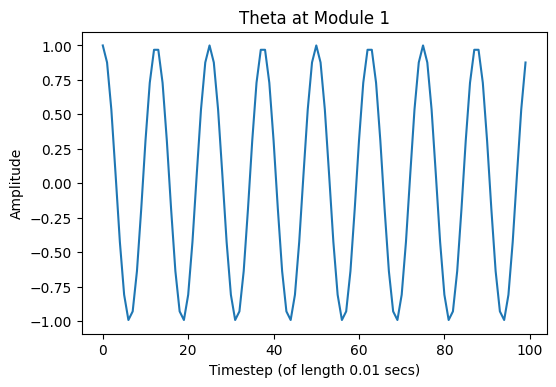

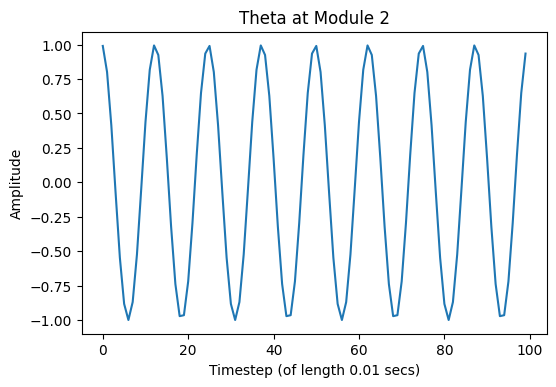

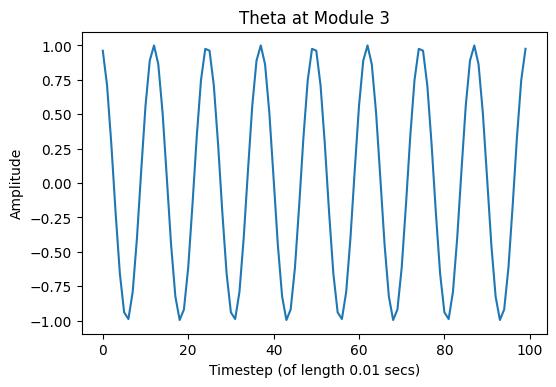

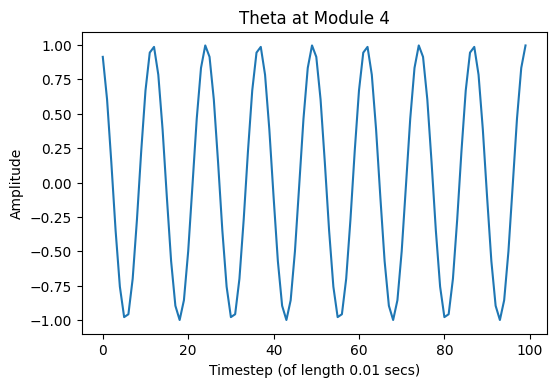

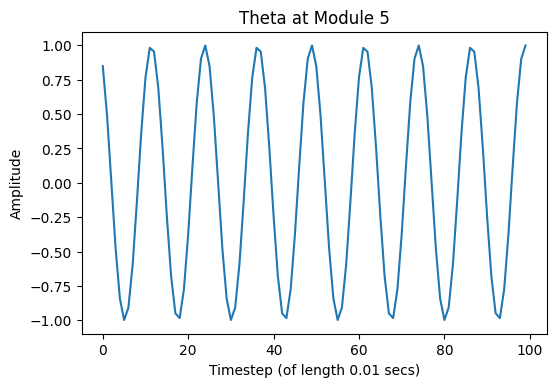

In [14]:
#@title Theta Rhythm
def theta_oscillations(args):
  """
  Generates theta oscillations incorporating the traveling wave.
  Assumption: all modules are lined up one after the other from the dorsal to
  the ventral end
  Inputs:
    args: ['nb_steps', 'timestep_size', 'theta_freq', 'nb_modules']
  Returns:
    theta: theta values for all modules all
           timesteps, shape:(nb_modules, nb_steps)
  """

  nb_steps = args['nb_steps']
  dt = args['timestep_size']
  freq = args['theta_freq']
  nb_modules = args['nb_modules']
  phi = args['phase_offset']

  pi = np.pi

  omega = 2*pi*freq
 
  phi =  phi * pi/180 # total theta phase offset from ventral to dorsal end

  theta = np.zeros((nb_modules, nb_steps))
  for i in range(nb_modules):
    theta[i] = np.arange(i*phi/nb_modules,
                                (i*phi/nb_modules) + (omega*dt*nb_steps),
                                omega*dt)
  return theta

def visualize_theta(theta, args):

  nb_modules = args['nb_modules'] 
  nb_steps = args['nb_steps']
  dt = args['timestep_size']
  
  for i in range(nb_modules):
    plt.figure(dpi=100)
    plt.plot(np.cos(theta[i]))
    plt.title("Theta at Module " + str(i + 1))
    plt.xlabel("Timestep (of length " + str(dt) + ' secs)')
    plt.ylabel("Amplitude")
    plt.show()

theta = theta_oscillations(args)
visualize_theta(theta, args)

In [15]:
#@title Firing Activity

def firing_activity(trajectory, modules, args):
  """
  Generates Firing Activity for all cells in all modules for a
  given trajectory.
  Assumption: Neurons show independent poisson spiking
  Inputs:
    trajectory: 2-D matrix with x & y coordinates in column 1 and 2, for the path
    modules - 3-D matrix with preferred phases
              of all cells in each module, shape: (nb_cells, 2, nb_modules)
    args: ['timestep_size', 'nb_modules', ]

  Returns:
    firing activity, shape: (nb_cells, nb_steps, nb_modules)
  """
  dt = args['timestep_size']
  nb_steps = args['nb_steps']
  nb_modules = args['nb_modules']
  nb_cells = args['nb_cells']
  freq = args['theta_freq']
  phi = args['phase_offset'] # total phase offset from dorsal to ventral end
  lam_0 = args['lam_0']
  s = args['scaling_ratio']
  pi = np.pi

  theta = theta_oscillations(args) # shape: (nb_modules, nb_steps)

  firing_activity = np.zeros((nb_cells, nb_steps, nb_modules))
  g_rec = np.zeros((nb_modules, nb_steps)
  )
  for t in range(nb_steps):

    position = trajectory[t]

    for j in range(nb_modules): # iterate from largest to smallest module
      lam = lam_0/(s**j)
      
      g = phase_modulation(theta[j, t], position, args) # shape: (1,)
      g_rec[j, t] = g
      f = von_mises(position, lam, modules[:, :, j], args) # shape: (nb_cells,)
      r = f * g # shape: (nb_cells,)
      firing_activity[:, t, j] = np.random.poisson(r*dt, size=nb_cells)

  return firing_activity, g_rec

def visualize_firing(ctivity, args, i=0):
  """
  Inputs:
    activity: shape(nb_cells, nb_steps)
    args
    i - module no. to visualize
  Returns:
    
  """
  nb_modules = args['nb_modules']
  nb_steps = args['nb_steps']
  dt = args['timestep_size']
  nb_cells = args['nb_cells']

  positions = np.arange(0, nb_steps, dt)
  positions = positions[activity != 0] 
  plt.eventplot(positions)
  plt.title("Module no: " + str(i + 1))
  plt.xlabel("Timestep")
  plt.ylabel("Cell No:")
  plt.show()



In [16]:
#@title Stationary Trajectory
def stationary_trajectory(x_coord, y_coord, args):
  """
  Generates stationary trajectory for given position coordinates
  for given nb_steps
  Inputs:
    x_coord:
    y_coord:
    args: ['nb_steps']
  Returns:
    trajectory: 
  """
  nb_steps = args['nb_steps']
  x = x_coord * np.ones(nb_steps)
  y = y_coord * np.ones(nb_steps)

  trajectory = np.column_stack((x, y))

  return trajectory


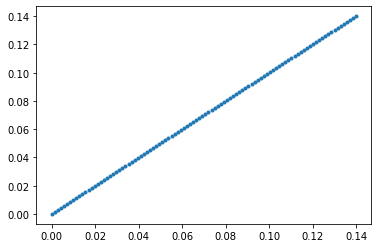

In [29]:
#@title Straight Trajectory

def straight_trajectory(angle, args):
  """

  """

  velocity = args['animal_velocity']
  dt = args['timestep_size']
  nb_steps = args['nb_steps']
  phi = angle * np.pi / 180

  x = np.arange(0, np.cos(phi)*velocity*dt*nb_steps,
                np.cos(phi)*velocity*dt)
  y = np.arange(0, np.sin(phi)*velocity*dt*nb_steps,
                np.sin(phi)*velocity*dt)

  trajectory = np.column_stack((x, y))

  return trajectory

trajectory = straight_trajectory(45, args)
plt.plot(trajectory[:, 0], trajectory[:, 1], '.')

In [ ]:
#@title Trajectory Plotter

def plot_trajectory(trajectory):
  """
  Inputs:

  Returns:

  """
  plt.plot(trajectory[:, 0], trajectory[:, 1], '.')
  plt.show()
  

In [17]:
#@title Populationg Vector Decoder for Single Module
def pop_decode(firing_activity, lam, args, module):
  """
  Generates population vector estimate based on giving firing activity
  of a single module
  Inputs:
    firing_activity - shape:(nb_cells, nb_steps)
    args - ['']
    module - shape: (nb_cells, 2)
  Returns:
    estimates - shape:(nb_steps,)
  """
  nb_steps = args['nb_steps']

  pi = np.pi

  k_1 = np.array([np.cos(pi/6), np.sin(pi/6)])
  k_2 = np.array([np.cos(pi/2), np.sin(pi/2)])
  k_3 = np.array([np.cos(pi*5/6), np.sin(pi*5/6)])

  plane_vectors = np.vstack((k_1, k_2, k_3)) # shape: (3, 2)

  w = 2*pi/(np.sin(pi/3)*lam)

  estimates = np.zeros((nb_steps, 2))

  for t in range(nb_steps):
    pop_vector = np.sum(firing_activity[:, t] *  np.exp(1j*w*(plane_vectors @ module.T )), axis=1) # final shape: (3,)
    mu = 1/w * np.angle(pop_vector) # shape: (3,)

    estimates[t] = (2/3) * (mu.T @ plane_vectors) #shape: (2,)

  return estimates

In [18]:
#@title Squared-Error
def sq_error(estimates, true_pos):
  """
  Evaluates squared error at each step from the true position
  Inputs:
    estimates - shape:(nb_steps, 2)
    true_pos - shape:(p, 2) where p = 1 or nb_steps
  Returns:
    mse_error - shape(nb_steps)
  """

  error = np.sum((estimates - true_pos)**2, axis=1) #shape: (nb_steps,)

  return error #shape: (nb_steps)

### Testing Everything

In [26]:
#@title Args

args = {'timestep_size': 0.01, # sec
        'nb_steps': 100, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

In [35]:
#@title Initializing Modules

modules = multi_uniform_modules(args)

In [ ]:
#@title Single timepoint

position = np.array([[6, 5]]) # shape: (1,2)
print("Actual Position:", position)
args['nb_steps'] = 1

activity, theta = firing_activity(position, modules, args)

# Estimating at Module - 0
estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])
print("Estimated Position:", estimates)


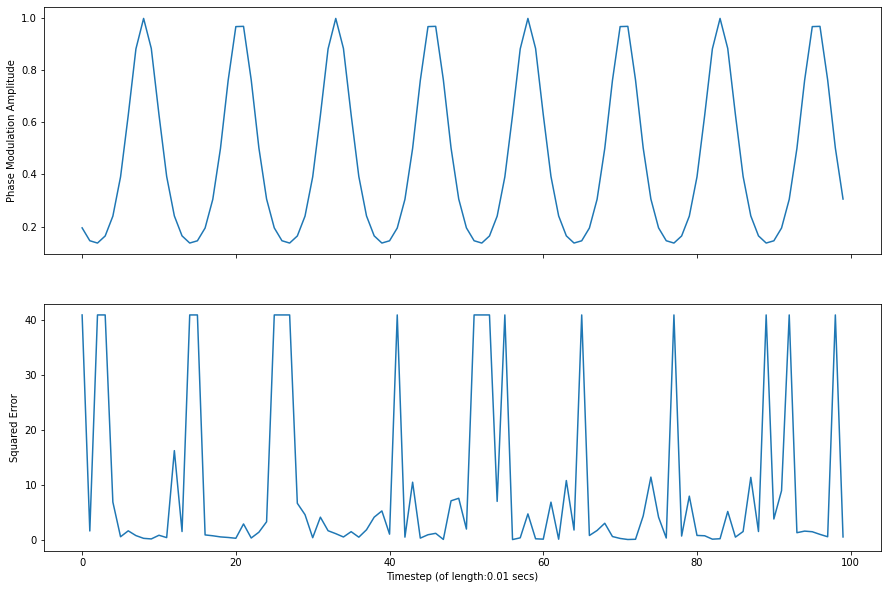

In [19]:
#@title Stationary Animal
x = 4
y = 5
trajectory = stationary_trajectory(x, y, args)

activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)


# Estimating at Module - 0
estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

error = sq_error(estimates, trajectory) #shape:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(error)

#visualize_firing(activity[:, :, 0], args, i=0)

Text(0.5, 1.0, 'Ensemble Phase Modulation and Decoding Error at Module 0')

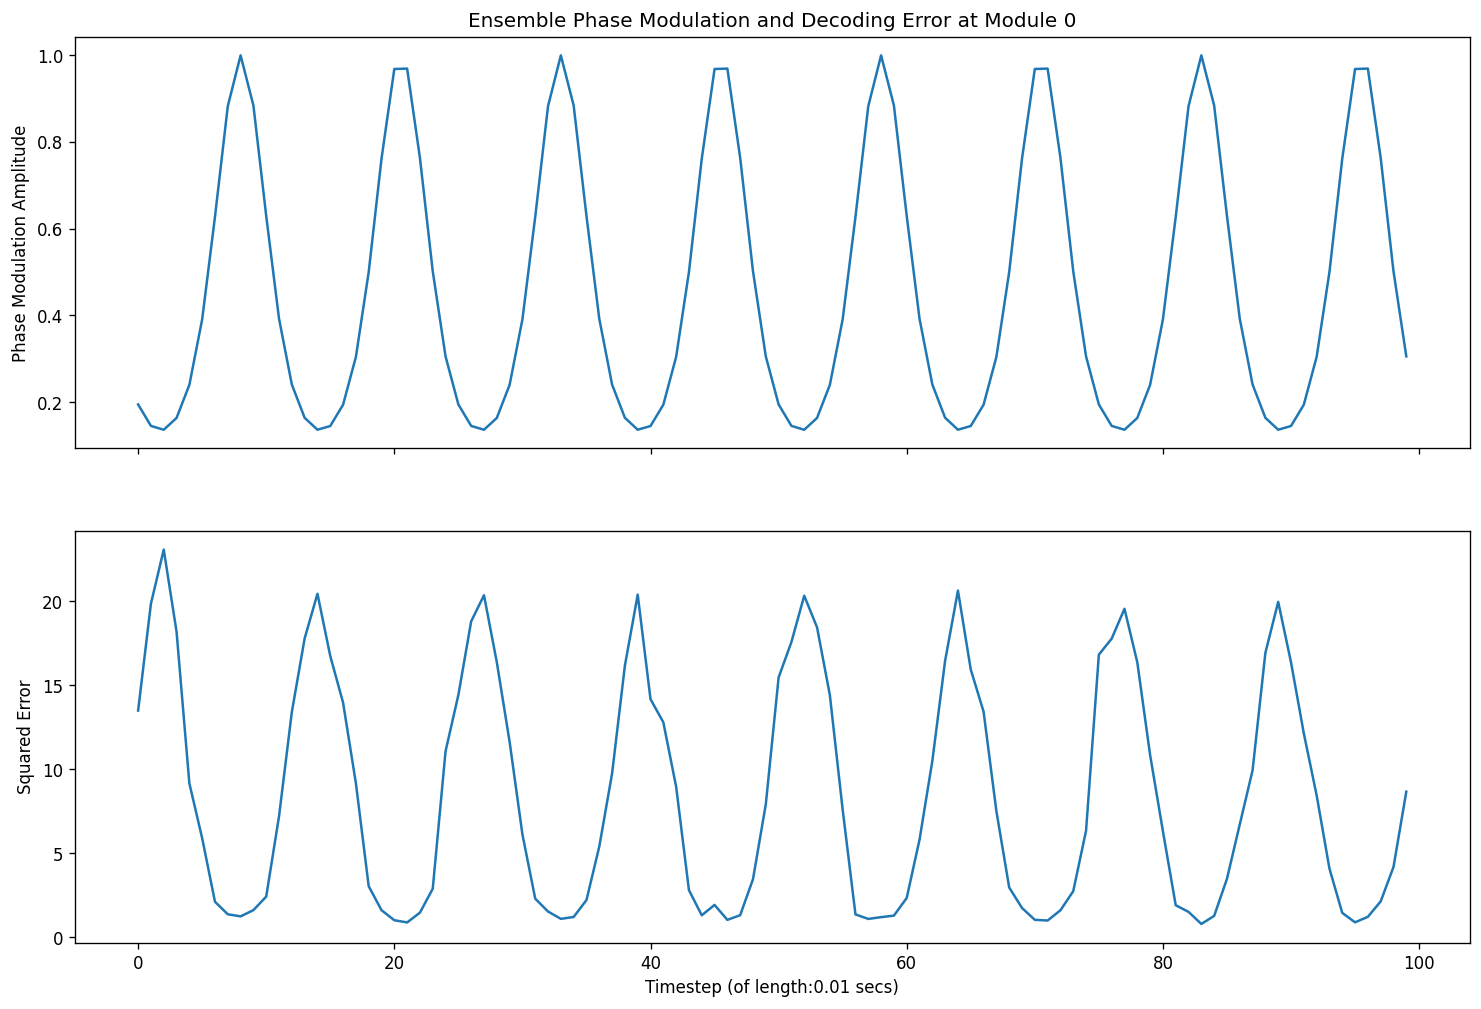

In [25]:
#@title Ensemble for Stationary Animal

args = {'timestep_size': 0.01, # sec
        'nb_steps': 100, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

nb_trials = 100

error_trials = np.zeros((nb_trials, args['nb_steps']))


x = 4
y = 5
trajectory = stationary_trajectory(x, y, args)

for i in range(nb_trials):
  activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)

  # Estimating at Module - 0
  estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

  error_trials[i] = sq_error(estimates, trajectory) #shape:(nb_steps)

avg_sq_error = (1/nb_trials)*np.sum(error_trials, axis=0)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10), dpi=120)
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(avg_sq_error)
axs[0].set_title("Ensemble Phase Modulation and Decoding Error at Module 0")

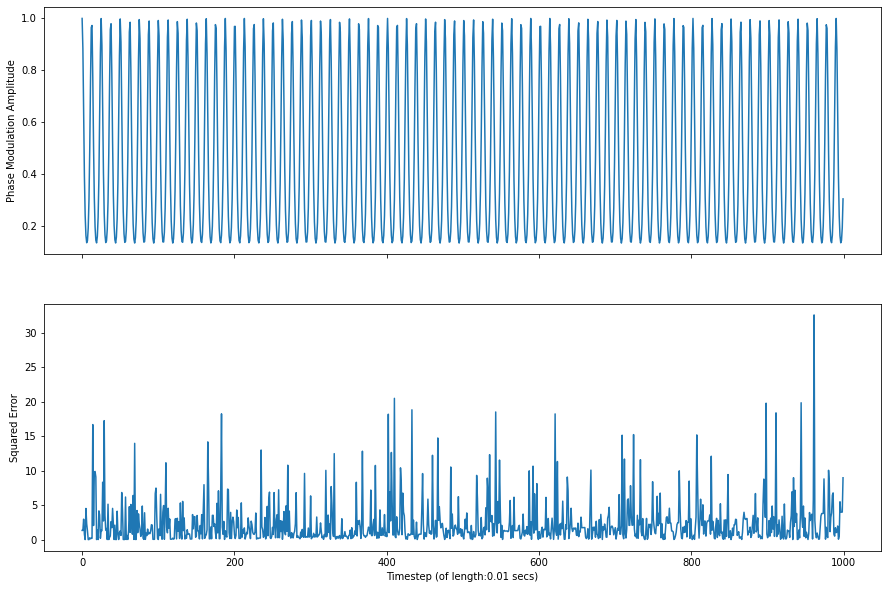

In [31]:
#@title Animal moving along a straight line

args = {'timestep_size': 0.01, # sec
        'nb_steps': 1000, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

trajectory = straight_trajectory(30, args)

activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)


# Estimating at Module - 0
estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

error = sq_error(estimates, trajectory) #shape:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(error)

100%|██████████| 100/100 [22:36<00:00, 13.57s/it]


Text(0.5, 1.0, 'Ensemble Phase Modulation and Decoding Error at Module 0')

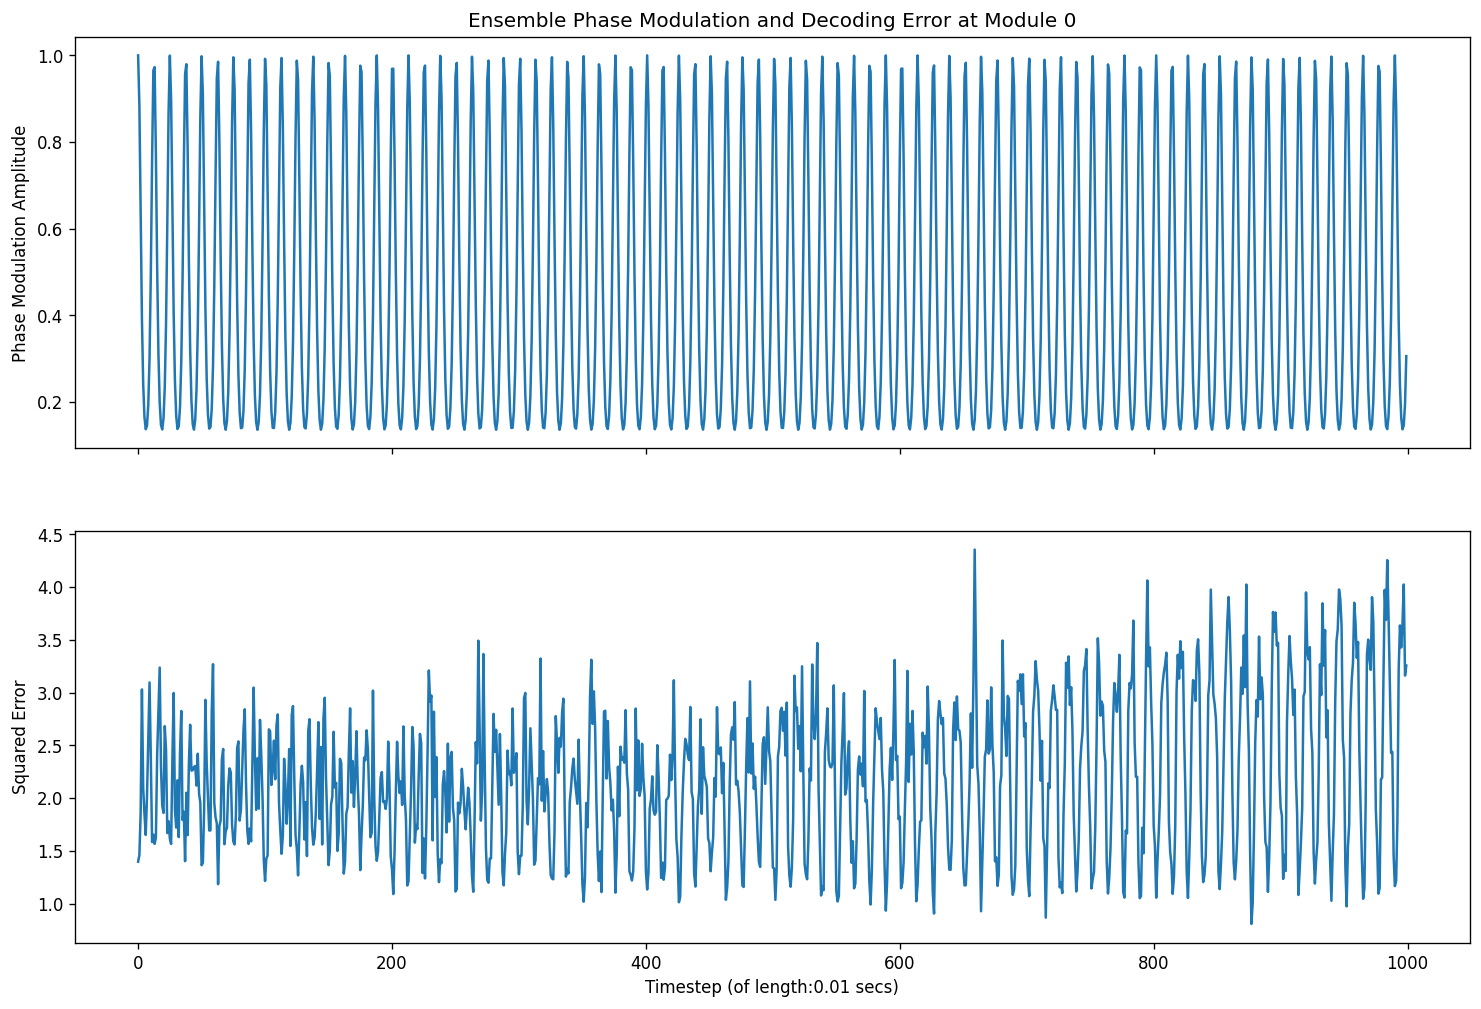

In [37]:
#@title Ensemble for Straight Trajectory

args = {'timestep_size': 0.01, # sec
        'nb_steps': 1000, # simulation time = dt*nb_steps (secs)
        'nb_modules': 5,
        'nb_cells': int(1e4),
        'lam_0': 100,  #spatial period of largest module (ventral)
        'K': 50, # von-Mises tuning width
        'n_max': 20, # maximum firing rate
        'animal_velocity': 0.2, # m/sec
        'theta_freq': 8,  # Hz
        'phase_offset': 40, # degrees 
        'scaling_ratio': 1.5,
        'k_theta': 1,
        'b_theta': 0,
        'm_theta': 2*np.pi/10, # rate of theta precession
        'ref_pos': np.array([[0, 0]]),  # reference position for theta precession
        }

nb_trials = 100
error_trials = np.zeros((nb_trials, args['nb_steps']))

trajectory = straight_trajectory(30, args)

for i in tqdm(range(nb_trials)):
  activity, g_rec = firing_activity(trajectory, modules, args) # shape: (nb_cells, nb_steps, nb_modules)

  # Estimating at Module - 0
  estimates = pop_decode(activity[:, :, 0], args['lam_0'], args, modules[:, :, 0])

  error_trials[i] = sq_error(estimates, trajectory) #shape:(nb_steps)

avg_sq_error = (1/nb_trials)*np.sum(error_trials, axis=0)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10), dpi=120)
axs[0].plot(g_rec[0])
axs[0].set_ylabel("Phase Modulation Amplitude")
axs[1].set_xlabel("Timestep (of length:" + str(args['timestep_size']) + ' secs)')
axs[1].set_ylabel("Squared Error")
axs[1].plot(avg_sq_error)
axs[0].set_title("Ensemble Phase Modulation and Decoding Error at Module 0")
